In [1]:
"""
notebook: 1.1.-leibold-simmler-data-modeling_shapValueAnalysis_aggregation.jpynb

author: Christian Leibold, Alke Simmler

created/updated at: 2025-12-04

intention: SHAP analysis on fitted model. 

content:
---------
-> reads in data, fitted pipeline and fitted model to get ready to evaluate SHAP values fast. 
-> create summary_plot based on OLD SHAP api
-> create different plot based on NEW SHAP api
-> aggregate SHAP values
-> create plots for aggregated SHAP values
"""


'\nnotebook: 1.1.-leibold-simmler-data-modeling_shapValueAnalysis_aggregation.jpynb\n\nauthor: Christian Leibold, Alke Simmler\n\ncreated/updated at: 2025-12-04\n\nintention: SHAP analysis on fitted model. \n\ncontent:\n---------\n-> reads in data, fitted pipeline and fitted model to get ready to evaluate SHAP values fast. \n-> create summary_plot based on OLD SHAP api\n-> create different plot based on NEW SHAP api\n-> aggregate SHAP values\n-> create plots for aggregated SHAP values\n'

In [20]:
# classic packages
import pandas as pd
import numpy as np
from joblib import dump, load

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# make custom libraries importable
import sys
sys.path.append('../../library')


# train_test_split
from sklearn.model_selection import train_test_split

# evaluation
import shap

# pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# little helper
from cleaning_utils import distinguish_cols, print_col_categories
import time

# warnings
import warnings
warnings.filterwarnings("ignore")


In [21]:
# 1. loading fitted objects
# ----------------------------------------------
# load data -> CAUTION: you need to place the concat file in a local folder and adjust the path accordingly
#df = load(r'..\..\..\temp_data\1.2-leibold-data-preprocessing_concat.joblib')
df = load(r'_local/1.2-leibold-data-preprocessing_concat.joblib')

# load fitted pipeline
#preprocessing_pipeline = load("../../models//pipeline_rf_over_under_2019_2023.pkl")
preprocessing_pipeline = load("../../models/pipeline_rf_over_under_2019_2023.pkl")

# load fitted model
model = load("../../models/model_rf_over_under_2019_2023.joblib")


# 2. Separate features and target
# ----------------------------------------------
X = df.drop(columns=['ind_severity'])   # predictors
y = df['ind_severity']                  # target


# 3. Stratified subsample for SHAP explanation
# ----------------------------------------------
# train_size can also be much higher when using approximate=True in SHAP explainer
X_sub, _, y_sub, _ = train_test_split(X, y, train_size=10000, stratify=y, random_state=42)

# Transform subsample with pipeline
X_sub_clean = preprocessing_pipeline.transform(X_sub)


ℹ️ AggrLocaSplit -> Aggregated from 10000 rows to 9989 groups.


In [22]:
# ----------------------------------------------
# display X_sub.info()
# ----------------------------------------------

pd.set_option('display.max_columns', None)

display(X_sub.head(3))
#X_sub.info()


,acc_num,ind_place,ind_cat,ind_sex,ind_trip,ind_secu1,ind_secu2,ind_location,ind_action,ind_year,ind_age,ind_age_group,ind_temp_id,acc_date,acc_year,acc_month,acc_hour,acc_department,acc_municipality,acc_metro,acc_long,acc_lat,acc_ambient_lightning,acc_atmosphere,acc_urbanization_level,acc_intersection,acc_collision_type,veh_cat,veh_fixed_obstacle,veh_moving_obstacle,veh_impact,veh_maneuver,veh_motor,veh_id,loca_road_cat,loca_traffic_circul,loca_road_lanes,loca_road_gradient,loca_road_view,loca_road_surface_cond,loca_accident,loca_max_speed,loca_is_intersection
200455,202000030769,1,1,1,0,1,<NA>,0,0,2020,28,3,202000030769_154 688 237_200455,2020-03-28,2020,3,2,60,60060,1,2.232842,49.195139,3.0,1.0,1,6.0,6.0,7,12,0,1.0,1.0,1,154 688 237,4,3,2.0,1,1.0,1.0,7,110.0,0
707581,202400020308,2,2,2,5,1,9,<NA>,<NA>,2024,51,4,202400020308_155 746 030_665924,2024-08-30,2024,8,20,51,51108,1,4.371060,48.959560,1.0,1.0,2,2.0,3.0,7,2,2,7.0,1.0,1,155 746 030,5,1,1.0,1,1.0,1.0,1,50.0,1
302470,202100028569,1,1,1,0,1,<NA>,0,0,2021,25,3,202100028569_150 654_304037,2021-07-17,2021,7,19,74,74211,1,6.261091,46.114449,1.0,1.0,1,1.0,1.0,7,0,2,1.0,21.0,1,150 654,4,2,2.0,2,1.0,1.0,1,80.0,0


In [8]:
# create OLD SHAP api shap_values object (TreeExplainer)
# ----------------------------------------------
#explainer = shap.TreeExplainer(model)
#shap_values = explainer.shap_values(X_sub_clean, approximate=True)

#feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out()
#X_sub_df = pd.DataFrame(X_sub_clean, columns=feature_names)


In [23]:
# ----------------------------------------------
# create SHAP explainer, shap_values for aggregation
# ----------------------------------------------

feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out()
X_sub_df = pd.DataFrame(X_sub_clean, columns=feature_names)

explainer = shap.TreeExplainer(model, X_sub_df)
shap_values = explainer(X_sub_df, approximate=True)


In [10]:
# ----------------------------------------------
# check shapes
# ----------------------------------------------

#note: X_sub has different length from X_sub_df
df.shape #(762666, 44)
X_sub.shape #(10000, 43)
X_sub_clean.shape #(9989, 123)
X_sub_df.shape #(9989, 123)

shap_values_data_df = pd.DataFrame(shap_values.data, columns=feature_names)
shap_values_data_df.shape #(9989, 123) #shap_values.data same as X_sub_clean


(9989, 123)

In [24]:
# ----------------------------------------------
# SHAP: create aggregated shap values object:
#
# 1 create encoded features dictionary 
# 2 get column attributes
#
# 3 create decoded shap_values.data df
#   note: cyclic and ohe encodings are being decoded
#   features with one encoded column aren't decoded
#
# 4 create aggregated shap values
# 5 create aggregated shap values object
# ----------------------------------------------

import sys
import importlib
sys.path.insert(1, '../../library')

import decoding_utils
import shap_values_aggr

importlib.reload(decoding_utils)
importlib.reload(shap_values_aggr)

shap_values_r, df_new_shap_values, df_shap_data, columns_dict = shap_values_aggr.get_agg_shap_values_obj(shap_values, feature_names)

df_shap_data.head()


get_agg_shap_values: Processing items: 100%|██████████| 9989/9989 [00:01<00:00, 5094.10it/s]


,acc_hour,acc_month,acc_ambient_lightning,acc_urbanization_level,acc_intersection,acc_atmosphere,acc_collision_type,ind_place,ind_cat,ind_sex,ind_trip,ind_secu1,veh_cat,veh_fixed_obstacle,veh_moving_obstacle,veh_impact,veh_maneuver,veh_motor,acc_municipality,loca_road_lanes,loca_max_speed
0,4,11,3,1,1,1,2,1,1,1,5,1,7,0,2,4,99,1,1.834295,0.250000,0.500000
1,9,11,1,2,1,1,6,10,3,1,5,8,7,0,1,1,1,1,1.785839,0.333333,0.277778
2,18,11,5,2,2,2,3,1,1,2,1,8,1,0,2,1,1,5,1.804174,0.166667,0.277778
3,19,11,3,1,1,1,1,1,1,2,2,1,7,0,2,1,1,1,1.707968,0.166667,0.166667
4,10,11,1,1,1,2,7,1,1,1,5,1,7,13,0,9,17,0,1.635590,0.000000,0.444444


In [12]:
# ----------------------------------------------
# create aggregated shap value object
# ----------------------------------------------
'''
import sys
import importlib
sys.path.insert(1, '../../library')

import decoding_utils
import shap_values_aggr

importlib.reload(decoding_utils)
importlib.reload(shap_values_aggr)

columns_dict, _ = shap_values_aggr.create_features_dict(feature_names)

org_columns, encodings, encoded_lengths, prefixes, endings = shap_values_aggr.get_col_attributes(columns_dict)
col_bounderies = np.cumsum(encoded_lengths)

df_new_shap_values, new_shap_values_stacked_array, new_shap_values = shap_values_aggr.get_agg_shap_values(shap_values, org_columns, col_bounderies)

df_shap_data = shap_values_aggr.get_decoded_shap_data(shap_values, col_bounderies, encoded_lengths, encodings, org_columns, prefixes, endings)

shap_values_r = copy.deepcopy(shap_values)
shap_values_r.values = new_shap_values_stacked_array
shap_values_r.data = np.array(np.array(df_shap_data))
shap_values_r.feature_names = list(df_shap_data.columns)
df_shap_data
'''
print()

In [13]:
# ----------------------------------------------
# chech aggregated shap_values object dimensions
# ----------------------------------------------

shap_values.values.shape #(9989, 123, 4)
shap_values.data.shape #(9989, 123)
len(shap_values.feature_names) #123

shap_values_r.values.shape #(9989, 21, 4)
shap_values_r.data.shape #(9989, 21)
len(shap_values_r.feature_names) #21

shap_values_r.feature_names


['acc_hour',
 'acc_month',
 'acc_ambient_lightning',
 'acc_urbanization_level',
 'acc_intersection',
 'acc_atmosphere',
 'acc_collision_type',
 'ind_place',
 'ind_cat',
 'ind_sex',
 'ind_trip',
 'ind_secu1',
 'veh_cat',
 'veh_fixed_obstacle',
 'veh_moving_obstacle',
 'veh_impact',
 'veh_maneuver',
 'veh_motor',
 'acc_municipality',
 'loca_road_lanes',
 'loca_max_speed']

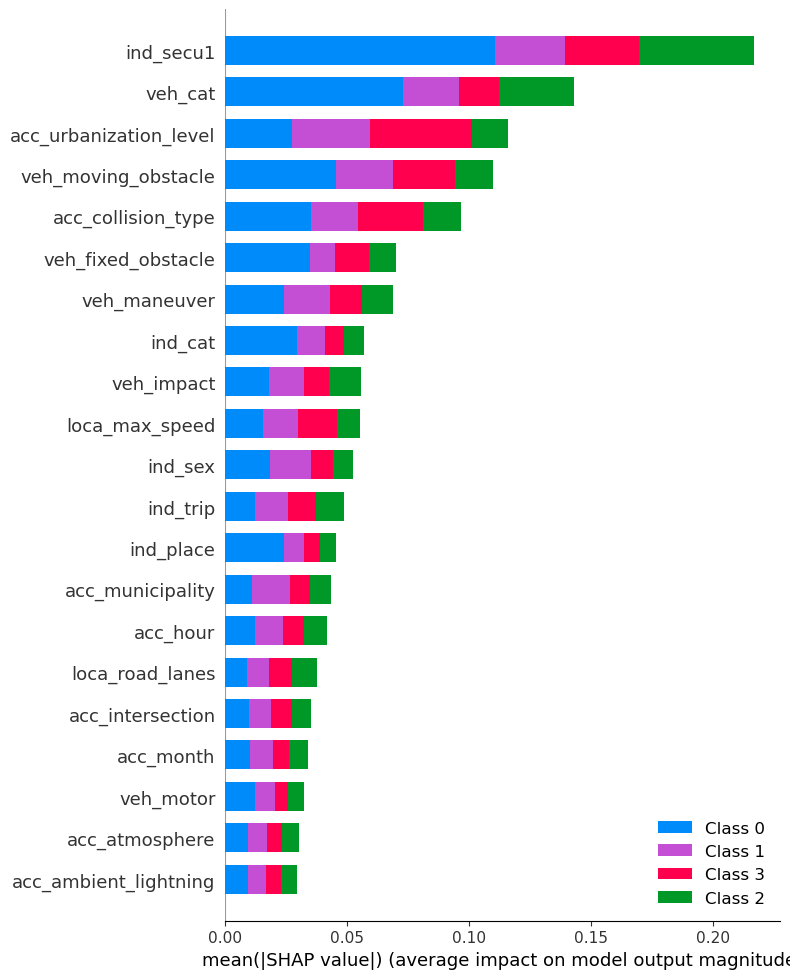

In [25]:
# ----------------------------------------------
# SHAP: create aggregated summary_plot
# 
# note: submit shap_values_r.data as 2nd paramter, the original dataframe of the same size cannot be accessed
# ----------------------------------------------

shap.summary_plot(shap_values_r, shap_values_r.data, plot_type="bar", max_display=30)


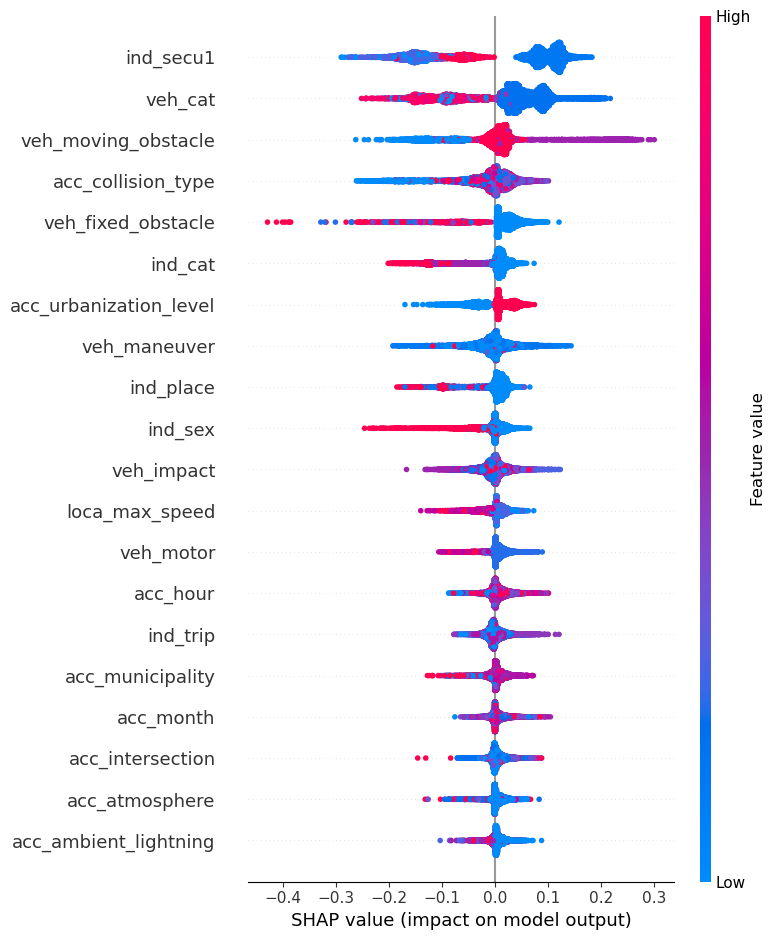

In [15]:
# -------------------------------------------------------------------------------------------------
# Shap: aggregated summary plot, class 0
# -------------------------------------------------------------------------------------------------

class_id = 0
shap.summary_plot(shap_values_r[:, :, class_id], shap_values_r.data)


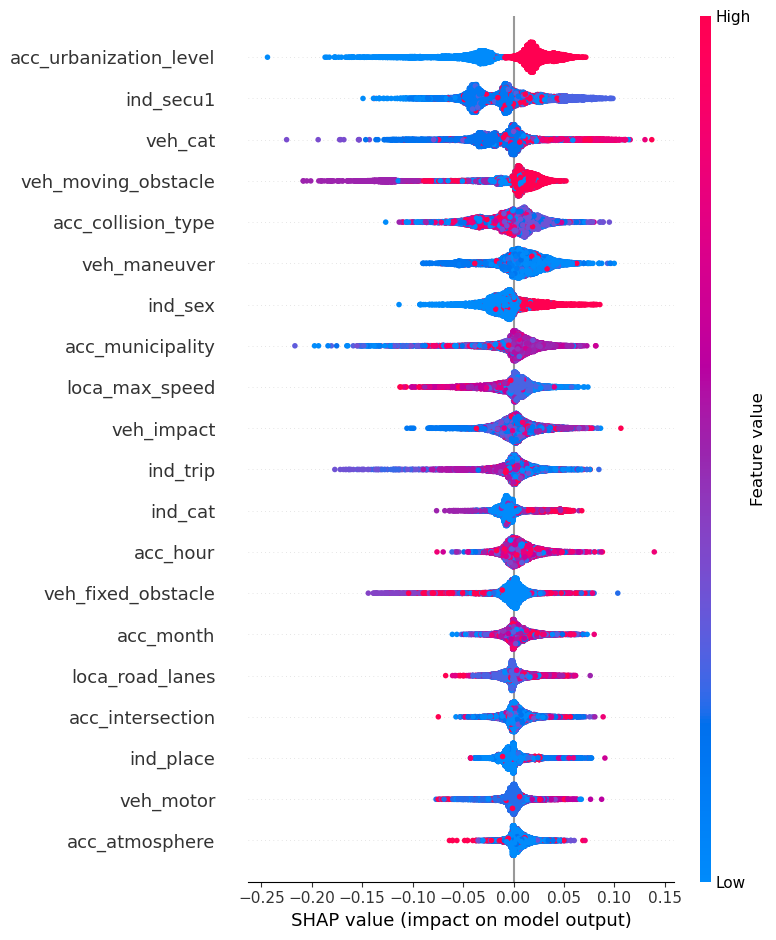

In [16]:
# -------------------------------------------------------------------------------------------------
# Shap: aggregated summary plot, class 1
# -------------------------------------------------------------------------------------------------

class_id = 1
shap.summary_plot(shap_values_r[:, :, class_id], shap_values_r.data)


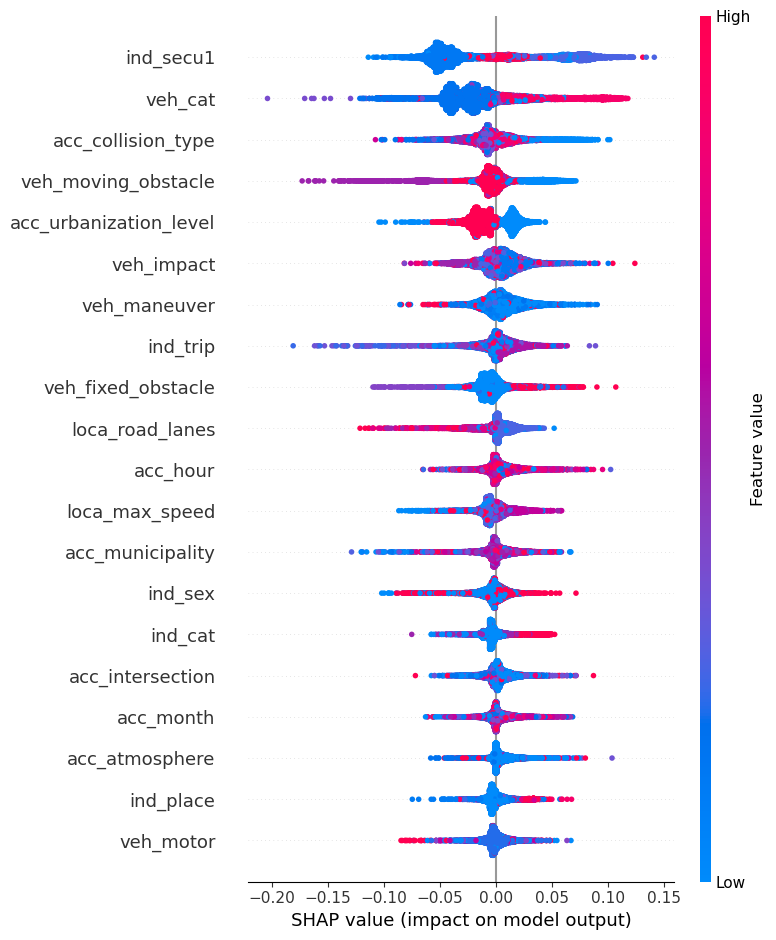

In [178]:
# -------------------------------------------------------------------------------------------------
# Shap: aggregated summary plot, class 2
# -------------------------------------------------------------------------------------------------

class_id = 2
shap.summary_plot(shap_values_r[:, :, class_id], shap_values_r.data)


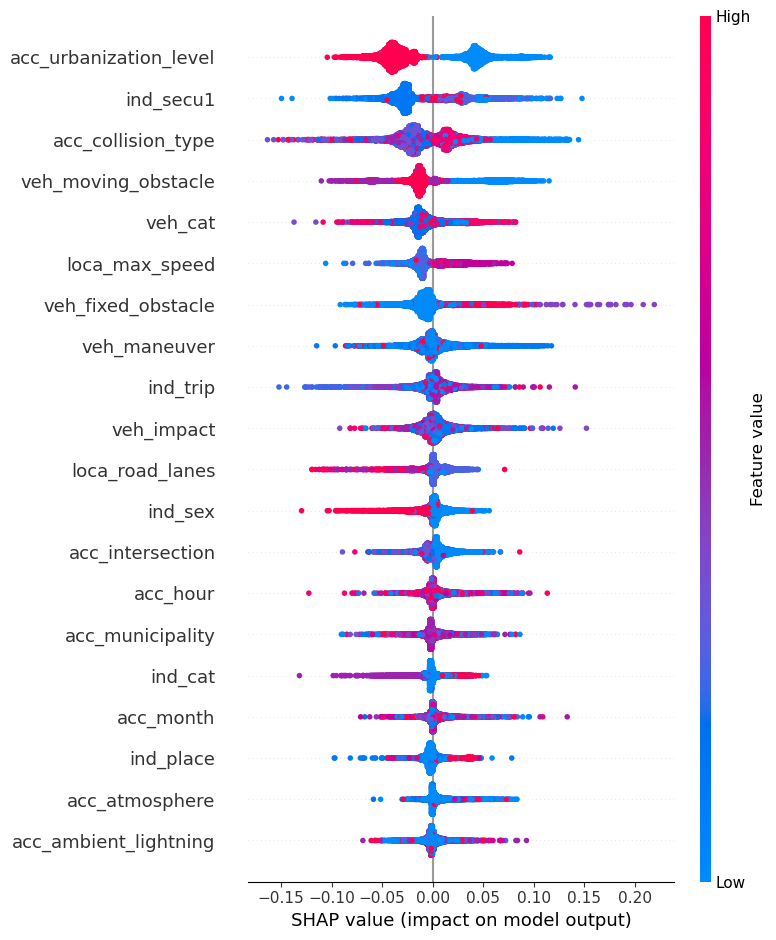

In [17]:
# -------------------------------------------------------------------------------------------------
# Shap: aggregated summary plot, class 3
# -------------------------------------------------------------------------------------------------

class_id = 3
shap.summary_plot(shap_values_r[:, :, class_id], shap_values_r.data)


In [180]:
# create OLD SHAP api shap_values object (TreeExplainer)
# ----------------------------------------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sub_clean, approximate=True)

feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out()
X_sub_df = pd.DataFrame(X_sub_clean, columns=feature_names)


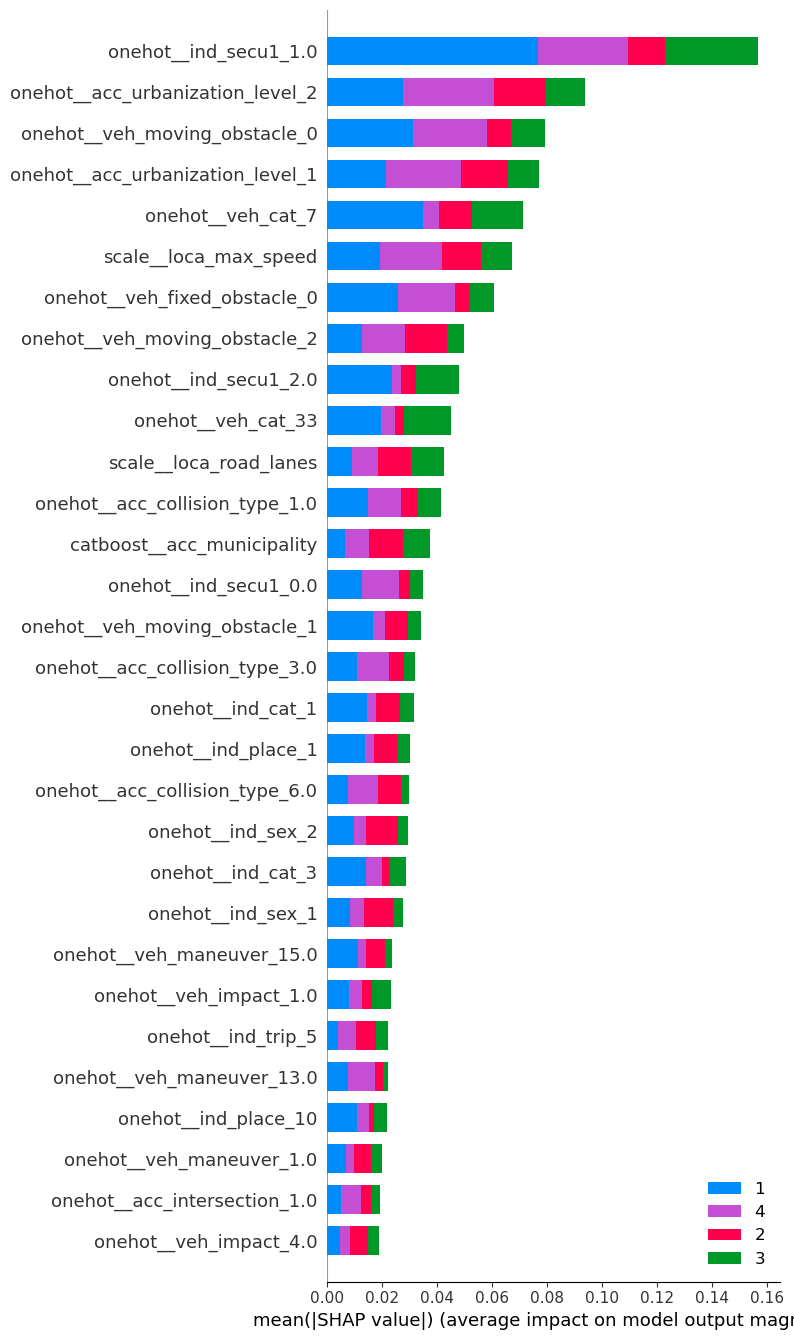

In [47]:
# OLD SHAP summary plot over all classes
# ----------------------------------------------
shap.summary_plot(shap_values, X_sub_df, plot_type="bar", class_names=model.classes_ , title="Top 50 Features Random Forest Model", max_display=30)


In [26]:
# NEW SHAP values -> whatch out: explainer object different from TreeExplainer!!
# ----------------------------
# Explainer object of new SHAP api
explainer = shap.Explainer(model)

# SHAP values with DATAFRAME as input (important to retain feature names)
shap_values = explainer(X_sub_df, approximate=True)


In [53]:
# Explainer object of new SHAP api
explainer_new = shap.Explainer(model, X_sub_clean)

# SHAP values with DATAFRAME as input (important to retain feature names)
shap_values_new = explainer_new(X_sub_df, approximate=True)


In [54]:
X_sub_clean.shape #(9989, 123)
X_sub_df.shape #(9989, 123)


(9989, 123)

In [55]:
# Shap aggregation: use new SHAP interface, ShapOneHotAggregator
# ----------------------------

importlib.reload(decoding_utils)
importlib.reload(shap_values_aggr)

aggregator = shap_values_aggr.ShapOneHotAggregator(shap_values_new.feature_names)
explainer_agg, mapping = aggregator.aggregate(shap_values_new.values, shap_values_new.data)


In [57]:
explainer_agg.values
explainer_agg.data
explainer_agg.feature_names

df_explainer_agg_data = pd.DataFrame(explainer_agg.data, columns=explainer_agg.feature_names)
df_explainer_agg_data.head()


,cyclical__acc_hour,cyclical__acc_month,acc_ambient_lightning,acc_urbanization_level,acc_intersection,acc_atmosphere,acc_collision_type,ind_place,ind_cat,ind_sex,ind_trip,ind_secu1,veh_cat,veh_fixed_obstacle,veh_moving_obstacle,veh_impact,veh_maneuver,veh_motor,catboost__acc_municipality,scale__loca_road_lanes,scale__loca_max_speed
0,1.0,1.0,onehot__3.0,onehot__1,onehot__1.0,onehot__1.0,onehot__2.0,onehot__1,onehot__1,onehot__1,onehot__5,onehot__1.0,onehot__7,onehot__0,onehot__2,onehot__4.0,onehot__99.0,onehot__1,1.834295,0.25,0.5
1,1.0,1.0,onehot__1.0,onehot__2,onehot__1.0,onehot__1.0,onehot__6.0,onehot__10,onehot__3,onehot__1,onehot__5,onehot__8.0,onehot__7,onehot__0,onehot__1,onehot__1.0,onehot__1.0,onehot__1,1.785839,0.333333,0.277778
2,1.0,1.0,onehot__5.0,onehot__2,onehot__2.0,onehot__2.0,onehot__3.0,onehot__1,onehot__1,onehot__2,onehot__1,onehot__8.0,onehot__1,onehot__0,onehot__2,onehot__1.0,onehot__1.0,onehot__5,1.804174,0.166667,0.277778
3,1.0,1.0,onehot__3.0,onehot__1,onehot__1.0,onehot__1.0,onehot__1.0,onehot__1,onehot__1,onehot__2,onehot__2,onehot__1.0,onehot__7,onehot__0,onehot__2,onehot__1.0,onehot__1.0,onehot__1,1.707968,0.166667,0.166667
4,1.0,1.0,onehot__1.0,onehot__1,onehot__1.0,onehot__2.0,onehot__7.0,onehot__1,onehot__1,onehot__1,onehot__5,onehot__1.0,onehot__7,onehot__13,onehot__0,onehot__9.0,onehot__17.0,onehot__0,1.63559,0.0,0.444444


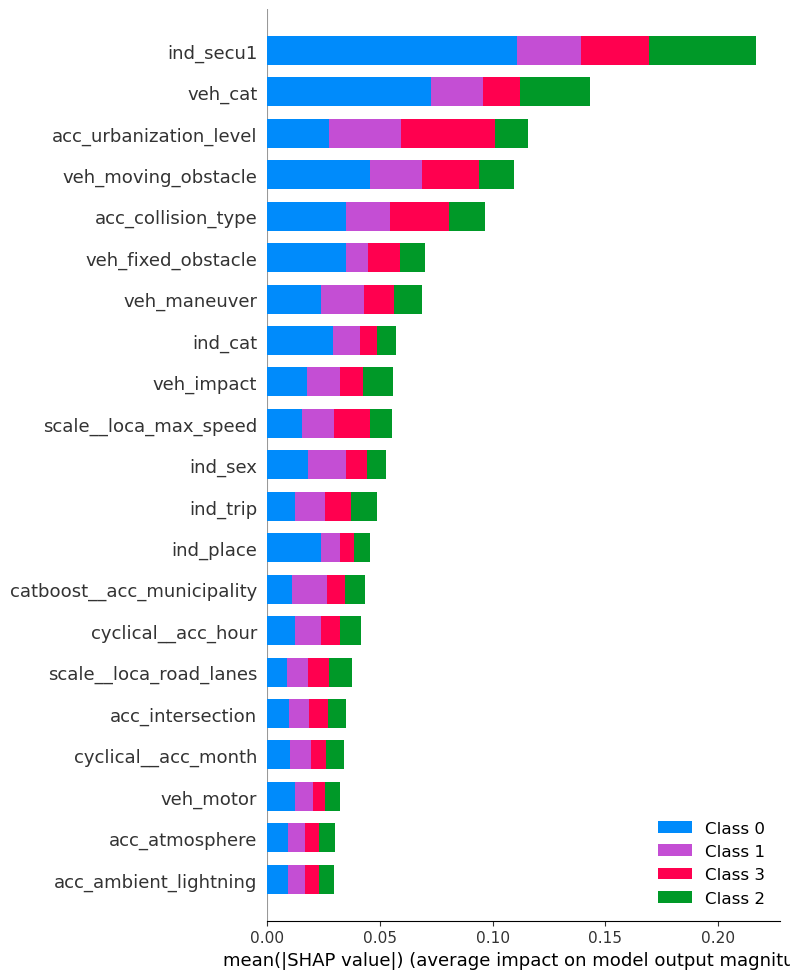

In [58]:
# Shap aggregation: summary plot with new interface
# ----------------------------

shap.summary_plot(explainer_agg.values, df_explainer_agg_data, plot_type="bar", max_display=30)


In [8]:
# check shape of new Explainer model 
# ----------------------------
# the order of shape objects matters!
# in most online code examples the order is: n_samples, n_classes, n_features
# here it is: n_samples, n_features, n_classes (I do not know why yet. but keep it so and the plots work)

# if necessary the order can be changed like this (do not do it by default, only if you get errors during plotting)
"""
shap_values = shap.Explanation(
    values=shap_values.values.transpose(0, 2, 1),
    base_values=shap_values.base_values,
    data=shap_values.data,
    feature_names=shap_values.feature_names
)
"""
print(shap_values.shape)          

(9989, 123, 4)


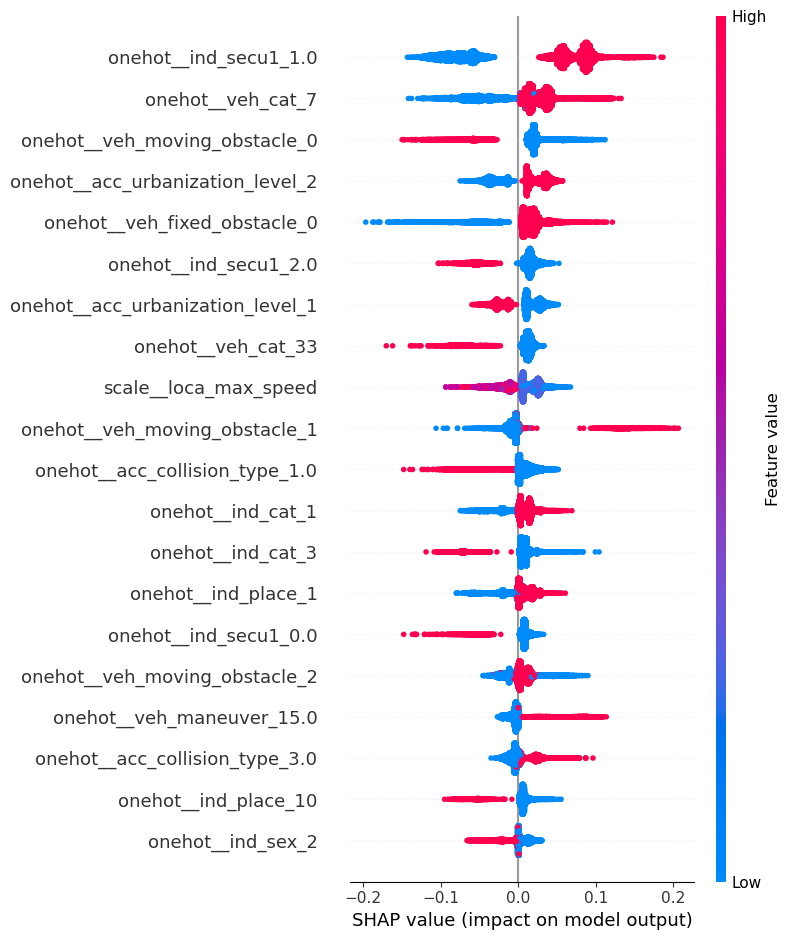

In [9]:
# NEW summary_plot per class
#--------------------------------------------------------------
shap.summary_plot(shap_values.values[:, :, 0], features=X_sub_df, feature_names=shap_values.feature_names)


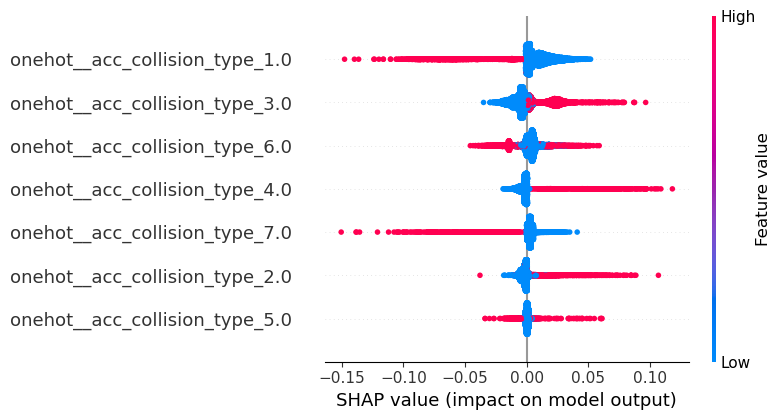

In [10]:
# NEW summary_plot only for subset of features
#--------------------------------------------------------------
# Get all feature names
all_features = shap_values.feature_names

# Filter names that start with the prefix
#prefix = "onehot__ind_secu1_"
prefix = "onehot__acc_collision_type_"
selected_features = [f for f in all_features if f.startswith(prefix)]

# Get indices of the selected features
selected_idx = [all_features.index(f) for f in selected_features]

# Slice SHAP values for class 0 and only those features
shap_subset = shap_values.values[:, selected_idx, 0]

X_subset = X_sub_df[selected_features]

shap.summary_plot(
    shap_subset,
    features=X_subset,
    feature_names=selected_features
)


Summary plot for class 0


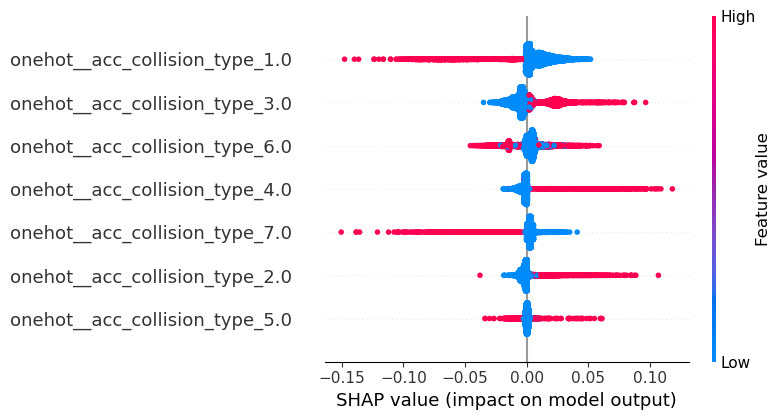

Summary plot for class 1


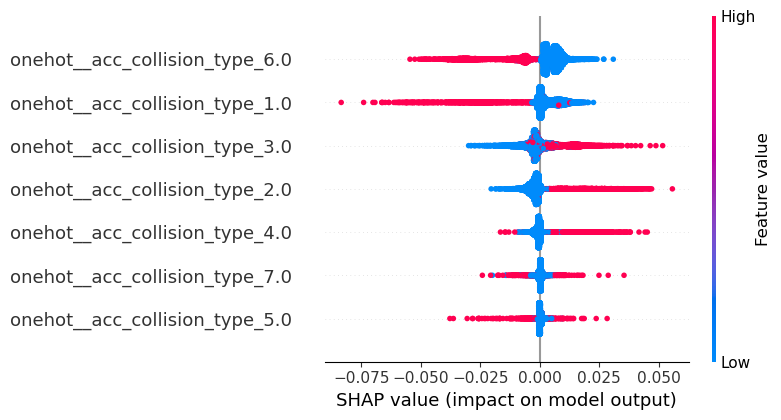

Summary plot for class 2


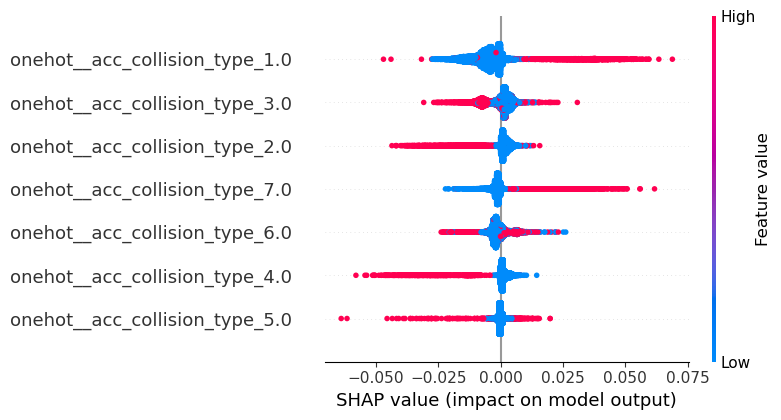

Summary plot for class 3


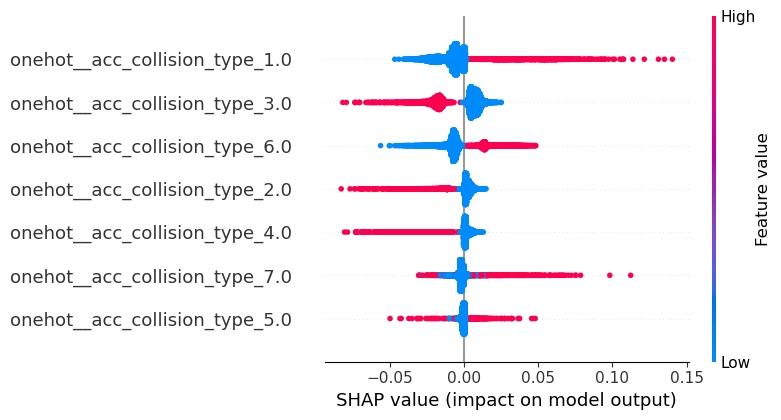

In [39]:
# NEW summary_plot looped over all classes with subset of features
#--------------------------------------------------------------
for c in range(shap_values.values.shape[-1]):  # iterate over classes
    shap_subset = shap_values.values[:, selected_idx, c]
    X_subset = X_sub_df[selected_features]
    print(f"Summary plot for class {c}")
    shap.summary_plot(
        shap_subset,
        features=X_subset,
        feature_names=selected_features,
        max_display=len(selected_features)
    )

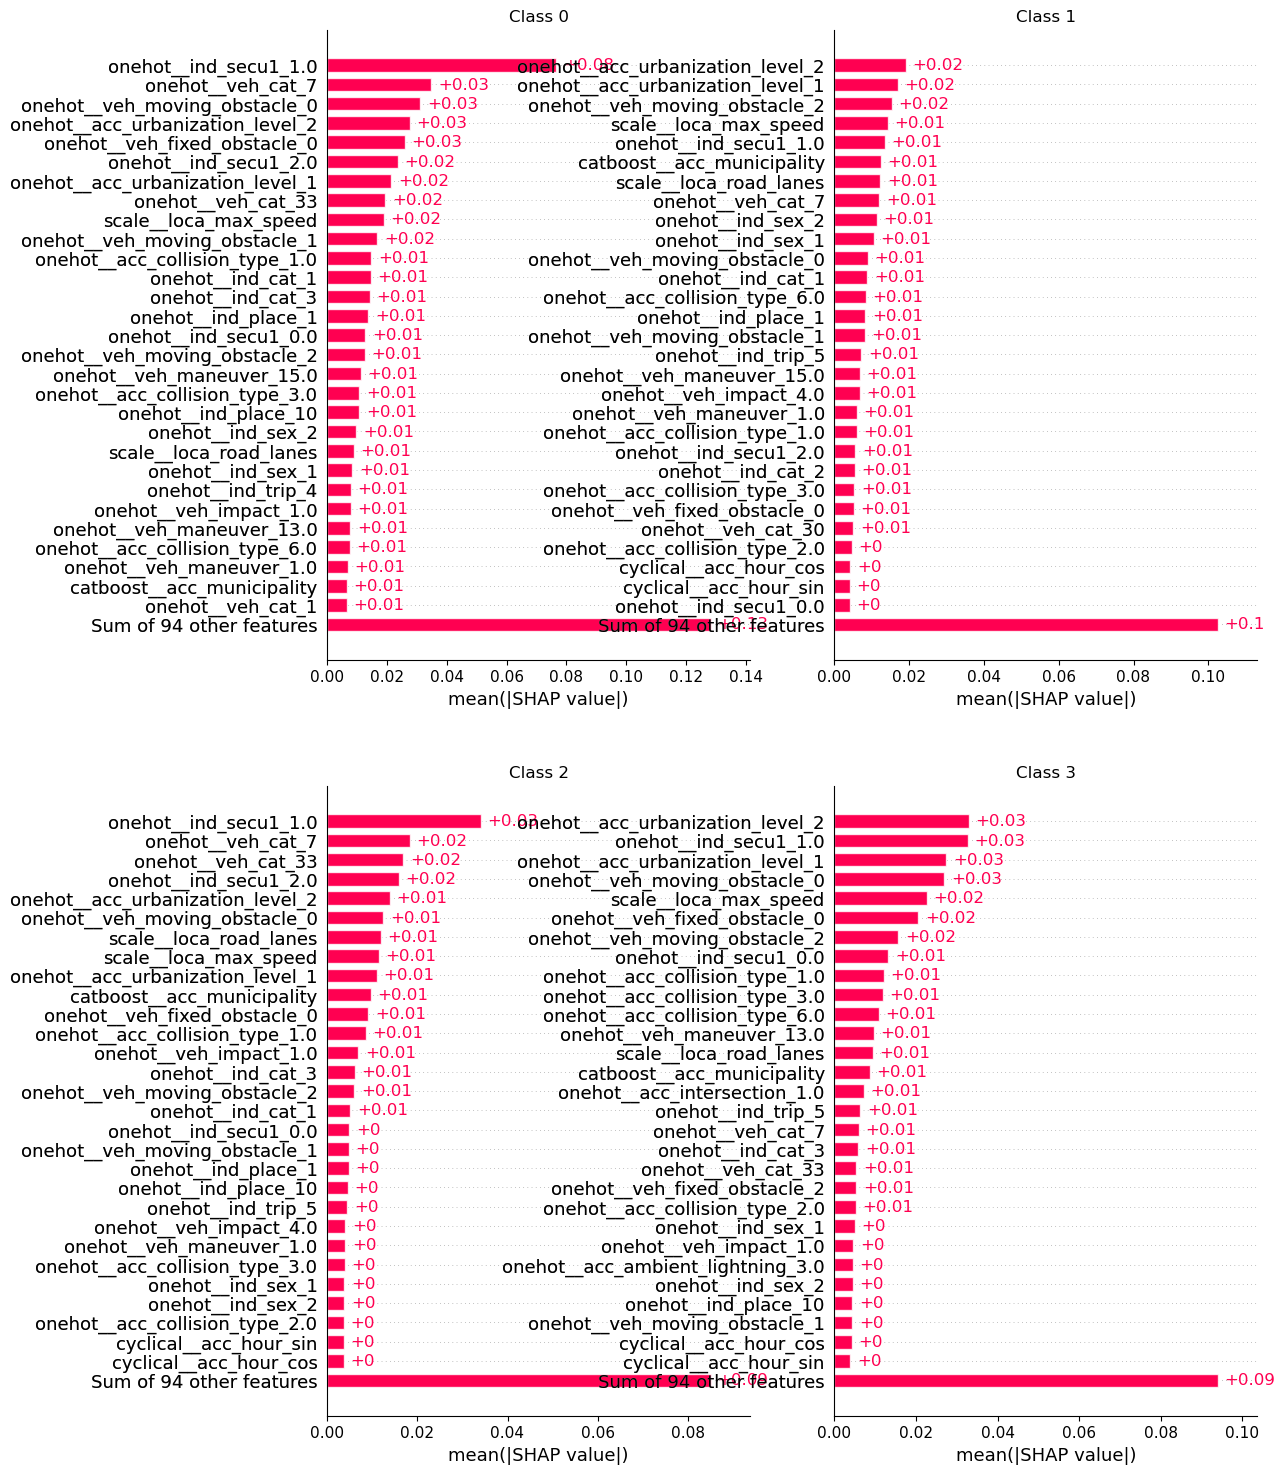

In [40]:
# NEW bar plot per class
#--------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 18))
axes = axes.flatten()

for c in range(shap_values.values.shape[-1]):
    shap.plots.bar(shap_values[:, :, c], max_display=30, show=False, ax=axes[c])
    axes[c].set_title(f"Class {c}")

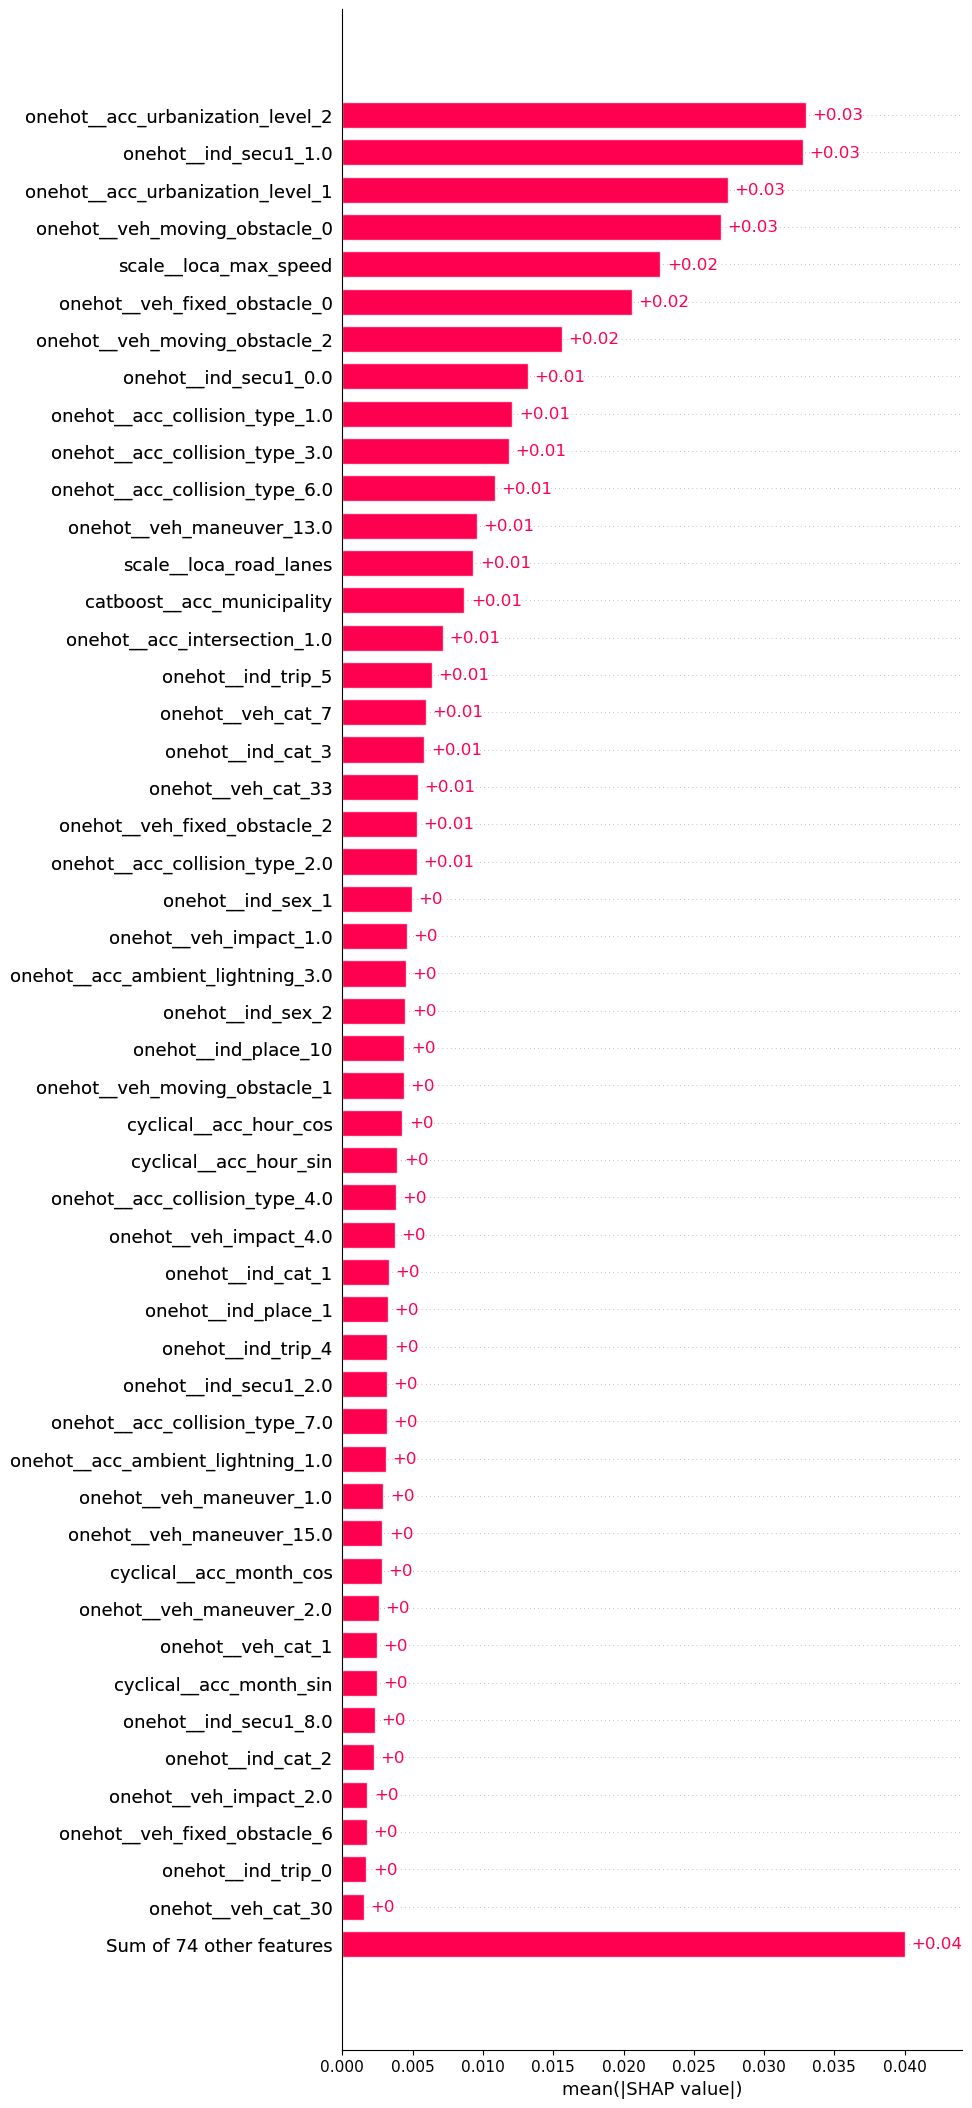

In [41]:
# NEW bar plot for single class
#--------------------------------------------------------------
# use indices for classes: 0,1,2,3
shap.plots.bar(shap_values[:, :, 3], max_display=50)


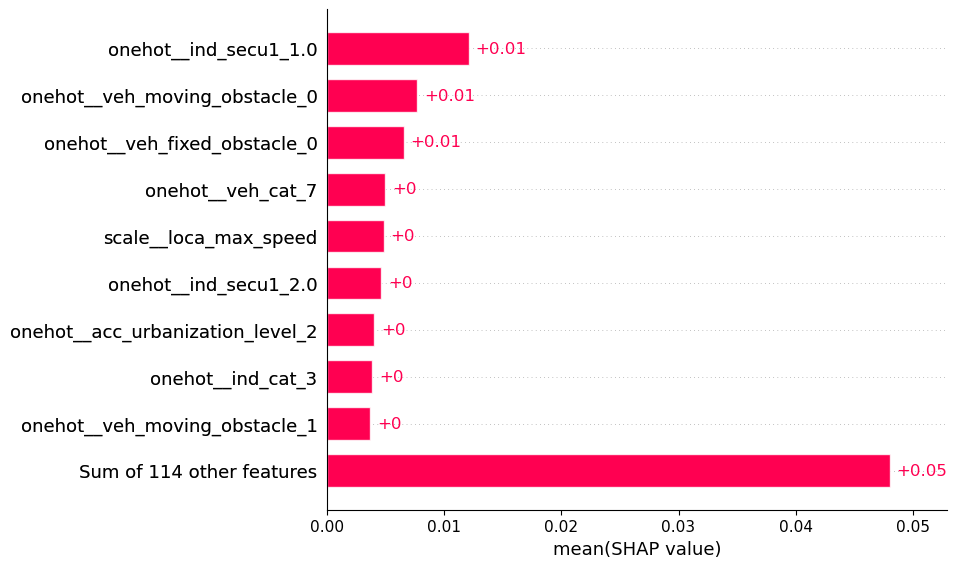

In [24]:
# NEW SHAP: bar plot for single class with mean impact 
#--------------------------------------------------------------
shap.plots.bar(shap_values[:, :, 0].mean(0))

In [48]:
# NEW check architecture of SHAP values
#--------------------------------------------------------------
print(type(shap_values), end="\n\n")          # shap._explanation.Explanation
print(shap_values.shape, end="\n\n")          # (n_samples, n_classes, n_features) for multiclass
print(shap_values.values.shape, end="\n\n")   # same as above, the raw SHAP values
print(shap_values.base_values, end="\n\n")    # expected value(s) for each output
print(shap_values.data, end="\n\n")           # the input data (X_sub_clean) used
print(shap_values.feature_names, end="\n\n")  # feature names if you passed a DataFrame

<class 'shap._explanation.Explanation'>

(9989, 123, 4)

(9989, 123, 4)

[[0.2502473  0.24996599 0.24990329 0.24988342]
 [0.2502473  0.24996599 0.24990329 0.24988342]
 [0.2502473  0.24996599 0.24990329 0.24988342]
 ...
 [0.2502473  0.24996599 0.24990329 0.24988342]
 [0.2502473  0.24996599 0.24990329 0.24988342]
 [0.2502473  0.24996599 0.24990329 0.24988342]]

[[ 8.66025404e-01  5.00000000e-01 -5.00000000e-01 ...  1.83429504e+00
   2.50000000e-01  5.00000000e-01]
 [ 7.07106781e-01 -7.07106781e-01 -5.00000000e-01 ...  1.78583935e+00
   3.33333333e-01  2.77777778e-01]
 [-1.00000000e+00 -1.83697020e-16 -5.00000000e-01 ...  1.80417423e+00
   1.66666667e-01  2.77777778e-01]
 ...
 [-9.65925826e-01 -2.58819045e-01 -5.00000000e-01 ...  1.81329121e+00
   1.66666667e-01  3.88888889e-01]
 [-8.66025404e-01 -5.00000000e-01 -8.66025404e-01 ...  1.75950004e+00
   8.33333333e-02  2.77777778e-01]
 [ 7.07106781e-01 -7.07106781e-01 -5.00000000e-01 ...  1.75975127e+00
   6.66666667e-01  2.77777778e-01]]

[